<a href="https://colab.research.google.com/github/sazzeb/simulated-annealing/blob/main/CSCE_5214_Assignment_3_Report_Eko_Samuel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
!pip install -q hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 4.3 MB/s eta 0:00:00


In [141]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Sequence, Tuple
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from hmmlearn.hmm import GaussianHMM


## **Task 1**

In [13]:
def extract_data(filename):
    records = []
    with open(filename, 'r') as f:
        for row in f:
            if len(row) < 46:
                continue

            pid = row[25:28]
            try:
                value = int(row[41:45], 16)
            except ValueError:
                continue

            rpm = None
            speed = None

            if pid == '115':               # RPM PID
                rpm = value * 2
                speed = 0.0
            elif pid == '254':             # Speed PID
                rpm = 0.0
                speed = (value * 0.62137119) / 100
            else:
                continue                   # ignore unknown PIDs

            records.append({'RPM': rpm, 'Speed': speed})

    # build DataFrame and clean
    X = (pd.DataFrame(records)
           .dropna()
           .reset_index(drop=True)
           .apply(pd.to_numeric, errors='coerce')
           .fillna(0))

    # Remove rows where RPM or Speed is 0
    # X = X[(X['RPM'] != 0) & (X['Speed'] != 0)]

    return X[['RPM', 'Speed']]


In [14]:

fff_injection_df = extract_data('/content/sample_data/fff_injection_df.log')
rpm_injection_df = extract_data('/content/sample_data/no_injection_df.log')
no_injection_df = extract_data('/content/sample_data/rpm_injection_df.log')



In [15]:
scaler = StandardScaler()

In [16]:
fff_injection_df

,RPM,Speed
0,626.0,0.000000
1,0.0,0.000000
2,624.0,0.000000
3,0.0,0.000000
4,624.0,0.000000
...,...,...
14430,0.0,5.486708
14431,0.0,25.445150
14432,0.0,25.445150
14433,906.0,0.000000


In [18]:
fff_injection_df[['RPM_T', 'Speed_T']] = scaler.fit_transform(fff_injection_df[['RPM', 'Speed']])

In [19]:
rpm_injection_df[['RPM_T', 'Speed_T']] = scaler.fit_transform(rpm_injection_df[['RPM', 'Speed']])

In [20]:
no_injection_df[['RPM_T', 'Speed_T']] = scaler.fit_transform(no_injection_df[['RPM', 'Speed']])

In [21]:
fff_injection_df.describe()

,RPM,Speed,RPM_T,Speed_T
count,14435.000000,14435.000000,1.443500e+04,1.443500e+04
mean,204.939799,16.968587,7.875777e-18,2.618696e-16
std,405.795606,11.149419,1.000035e+00,1.000035e+00
min,0.000000,0.000000,-5.050496e-01,-1.521978e+00
25%,0.000000,5.486708,-5.050496e-01,-1.029854e+00
50%,0.000000,25.445150,-5.050496e-01,7.602959e-01
75%,0.000000,25.445150,-5.050496e-01,7.602959e-01
max,1772.000000,25.445150,3.861832e+00,7.602959e-01


In [22]:
rpm_injection_df.describe()

,RPM,Speed,RPM_T,Speed_T
count,1649.000000,1649.000000,1.649000e+03,1.649000e+03
mean,941.400849,7.217956,-3.447145e-17,5.170717e-17
std,945.948948,10.203310,1.000303e+00,1.000303e+00
min,0.000000,0.000000,-9.954939e-01,-7.076278e-01
25%,0.000000,0.000000,-9.954939e-01,-7.076278e-01
50%,756.000000,0.000000,-1.960540e-01,-7.076278e-01
75%,1974.000000,14.919122,1.091932e+00,7.550004e-01
max,2570.000000,29.987374,1.722179e+00,2.232249e+00


In [41]:
no_injection_df.describe()

,RPM,Speed,RPM_T,Speed_T
count,4.543000e+03,4.543000e+03,4.543000e+03,4.543000e+03
mean,-6.256154e-17,8.133001e-17,-2.502462e-17,6.256154e-17
std,1.000110e+00,1.000110e+00,1.000110e+00,1.000110e+00
min,-1.186355e+00,-4.436492e-01,-1.186355e+00,-4.436492e-01
25%,-1.174802e+00,-4.436492e-01,-1.174802e+00,-4.436492e-01
50%,8.490074e-01,-4.436492e-01,8.490074e-01,-4.436492e-01
75%,8.490074e-01,-4.436492e-01,8.490074e-01,-4.436492e-01
max,8.490074e-01,3.248646e+00,8.490074e-01,3.248646e+00


## **Task 2**

In [120]:
def k_means_plot(data, max_k):
    """Generate elbow plot to find optimal k"""
    means = []
    inertias = []

    # Compute inertia values for different k
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

    # Generate the elbow plot
    plt.figure(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()


In [58]:
def plot_kmeans_clusters(data, k=2):
    """Scatter plot showing fitted k-means clusters"""
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)

    plt.figure(figsize=(8, 6))
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='viridis', s=50)
    plt.scatter(kmeans.cluster_centers_[:, 0],
                kmeans.cluster_centers_[:, 1],
                s=200, c='red', marker='X', label='Centroids')
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.title(f'K-Means Clustering (k={k}): Attack = 0 vs Attack = 1')
    plt.legend()
    plt.show()


In [62]:
def kmeans_centroids_accuracy(df, known_labels=None):
    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(df[['RPM_T', 'Speed_T']])
    centroids = kmeans.cluster_centers_

    if known_labels is not None:
        acc1 = accuracy_score(known_labels, clusters)
        acc2 = accuracy_score(known_labels, 1 - clusters)
        accuracy = max(acc1, acc2)
        print(f"Accuracy: {accuracy}")
        return centroids, accuracy
    else:
        return centroids

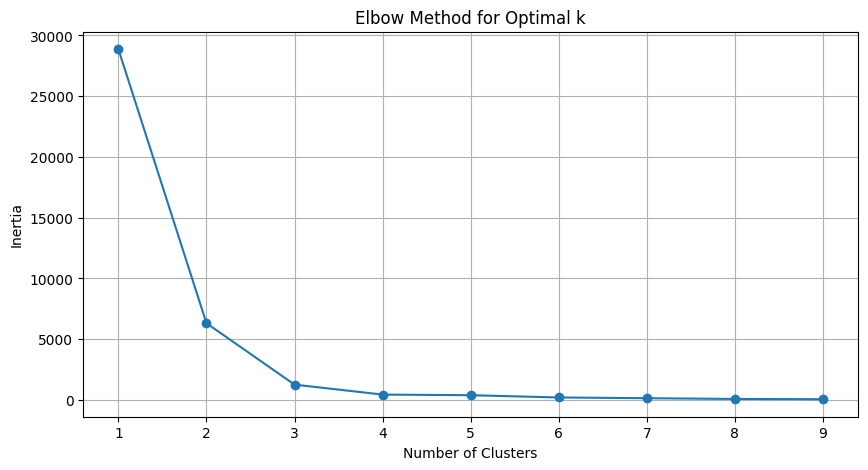

In [121]:
k_means_plot(fff_injection_df[['RPM_T', 'Speed_T']], 10)


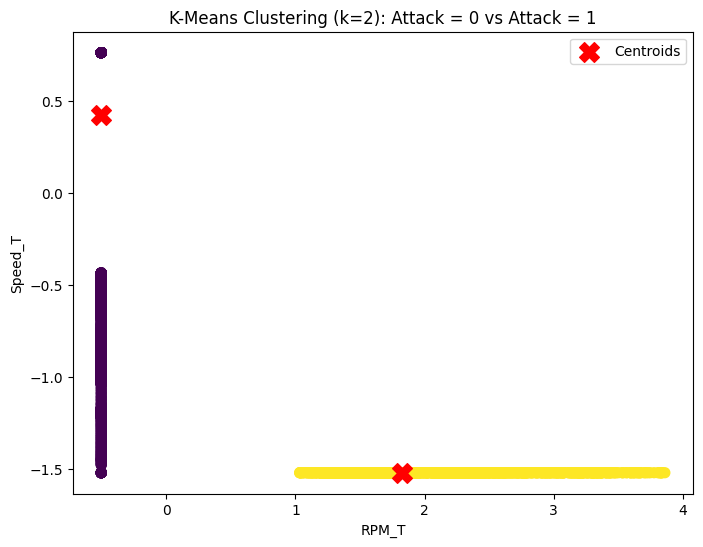

In [61]:
plot_kmeans_clusters(fff_injection_df[['RPM_T', 'Speed_T']], k=2)

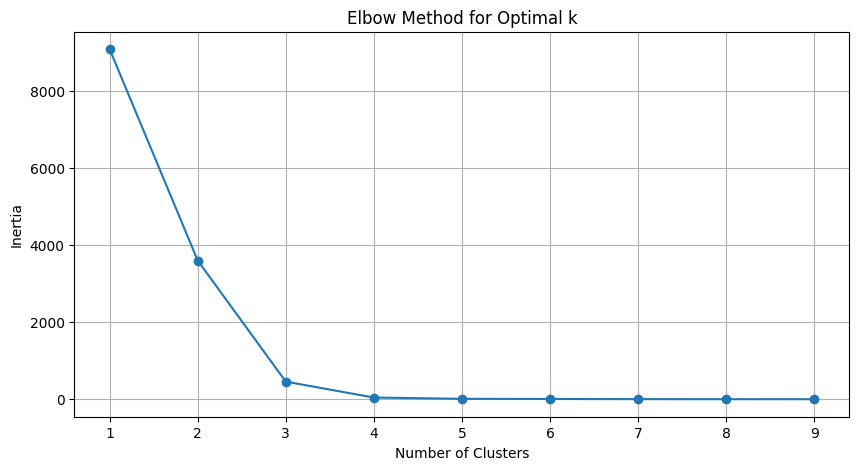

In [122]:
k_means_plot(no_injection_df[['RPM_T', 'Speed_T']], 10)

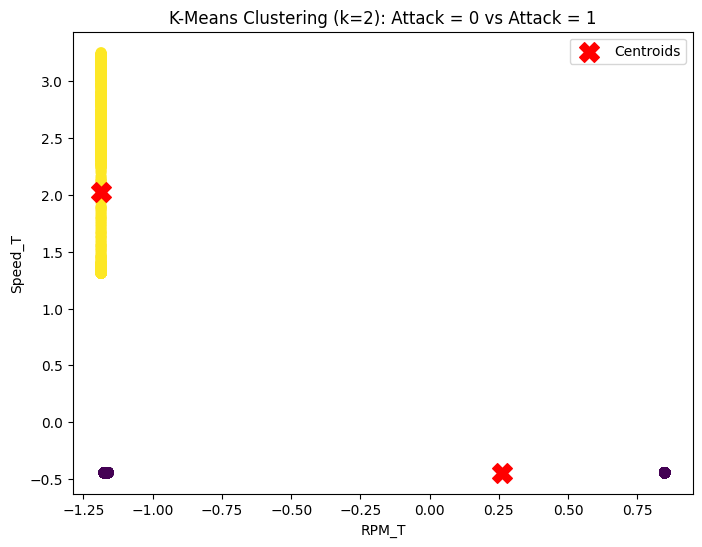

In [77]:
plot_kmeans_clusters(no_injection_df[['RPM_T', 'Speed_T']], k=2)

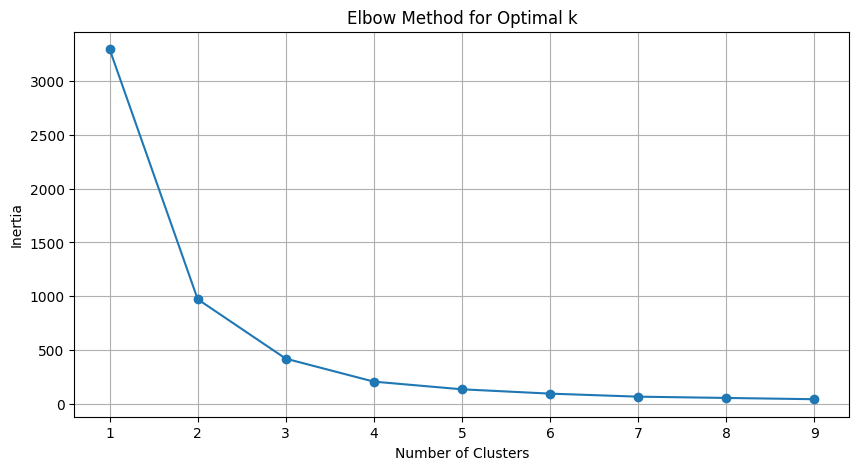

In [123]:
k_means_plot(rpm_injection_df[['RPM_T', 'Speed_T']], 10)

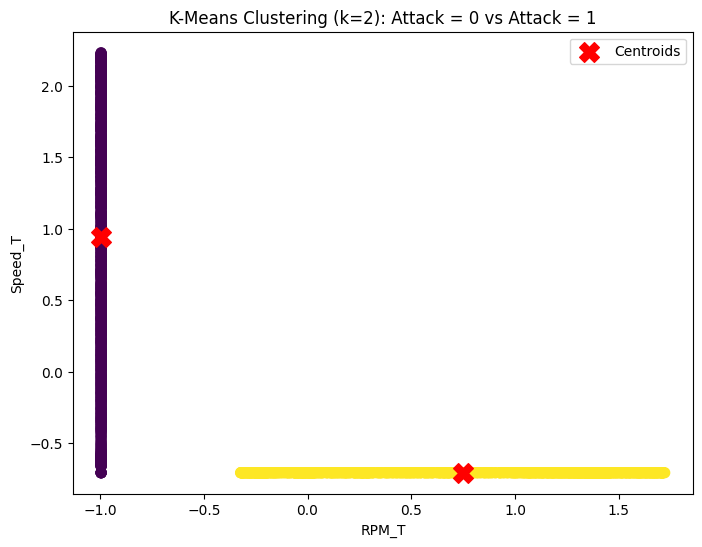

In [75]:
plot_kmeans_clusters(rpm_injection_df[['RPM_T', 'Speed_T']], k=2)

In [68]:
centroids = kmeans_centroids_accuracy(fff_injection_df)
fff_injection_df['Attack'] = np.random.randint(0, 2, len(fff_injection_df))
print(centroids)

[[-0.50504957  0.42121622]
 [ 1.82489309 -1.52197845]]


In [69]:
centroids, accuracy = kmeans_centroids_accuracy(fff_injection_df, fff_injection_df['Attack'])

Accuracy: 0.5004502944232767


In [81]:
centroids = kmeans_centroids_accuracy(no_injection_df)
no_injection_df['Attack'] = np.random.randint(0, 2, len(no_injection_df))
print(centroids)

[[ 0.25974394 -0.44364916]
 [-1.18635496  2.02632404]]


In [82]:
centroids, accuracy = kmeans_centroids_accuracy(no_injection_df, no_injection_df['Attack'])

Accuracy: 0.5025313669381466


In [83]:
centroids = kmeans_centroids_accuracy(rpm_injection_df)
rpm_injection_df['Attack'] = np.random.randint(0, 2, len(rpm_injection_df))
print(centroids)

[[-0.99549392  0.94283641]
 [ 0.74714883 -0.70762775]]


In [84]:
centroids, accuracy = kmeans_centroids_accuracy(rpm_injection_df, rpm_injection_df['Attack'])

Accuracy: 0.5100060642813826


Task 3

In [112]:
def isolation_forest_graphs(data, max_steps=10):
    contamination_rates = np.linspace(0.01, 0.15, max_steps)
    anomaly_counts = []

    for contamination in contamination_rates:
        iso = IsolationForest(contamination=contamination, random_state=42)
        preds = iso.fit_predict(data)
        anomaly_counts.append(np.sum(preds == -1))

    plt.figure(figsize=(10, 5))
    plt.plot(contamination_rates, anomaly_counts, 'o-')
    plt.xlabel('Contamination (expected anomaly rate)')
    plt.ylabel('Number of detected anomalies')
    plt.title('Isolation Forest: Anomalies Found vs Contamination Rate')
    plt.grid(True)
    plt.show()

In [116]:
def isolation_forest_scater_clusters(data, contamination=0.05):
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    preds = iso_forest.fit_predict(data)

    plt.figure(figsize=(8, 6))
    plt.scatter(
        data.iloc[:, 0][preds == 1],
        data.iloc[:, 1][preds == 1],
        c='blue', label='Inlier', alpha=0.6
    )
    plt.scatter(
        data.iloc[:, 0][preds == -1],
        data.iloc[:, 1][preds == -1],
        c='red', label='Anomaly', alpha=0.6
    )
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.title(f'Isolation Forest Detection (contamination={contamination})')
    plt.legend()
    plt.show()



In [118]:
def isolation_forest_anomalies_accuracy(df, known_labels=None,
                                        contamination=0.05):
    clf = IsolationForest(contamination=contamination, random_state=42)
    preds = clf.fit_predict(df)
    anomalies_df = df[preds == -1]
    print(anomalies_df.head())

    accuracy = None
    if known_labels is not None:
        preds_binary = (preds == -1).astype(int)
        acc1 = accuracy_score(known_labels, preds_binary)
        acc2 = accuracy_score(known_labels, 1 - preds_binary)
        accuracy = max(acc1, acc2)
        print(f"Accuracy: {accuracy}")

    return anomalies_df, accuracy


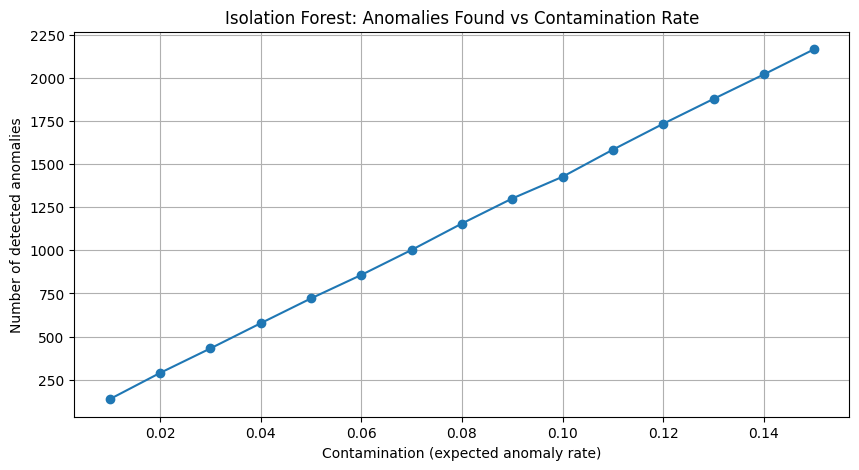

In [117]:
isolation_forest_graphs(fff_injection_df[['RPM_T', 'Speed_T']], 15)

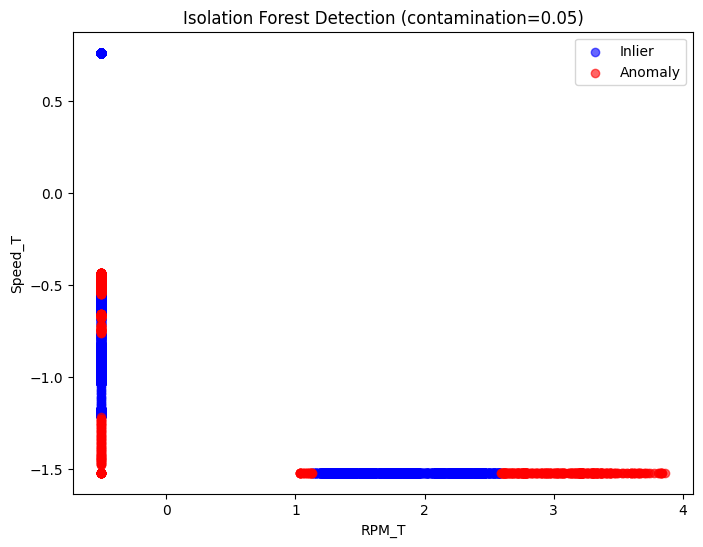

In [119]:
isolation_forest_scater_clusters(fff_injection_df[['RPM_T', 'Speed_T']],
                               contamination=0.05)

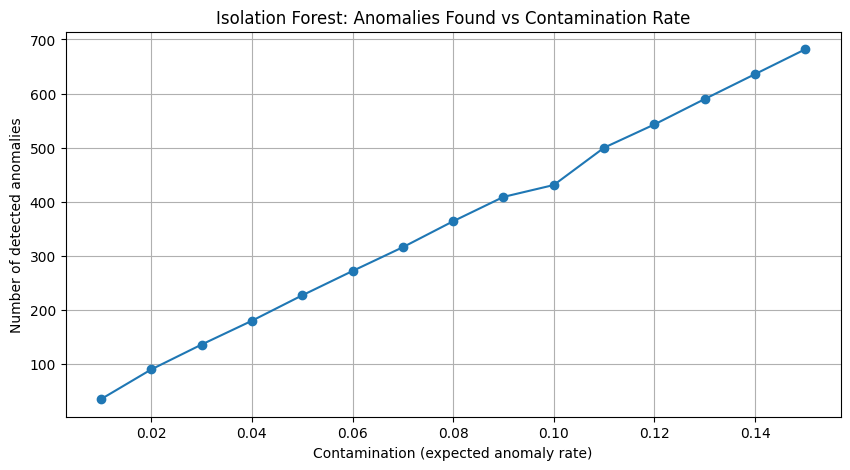

In [125]:
isolation_forest_graphs(no_injection_df[['RPM_T', 'Speed_T']], 15)

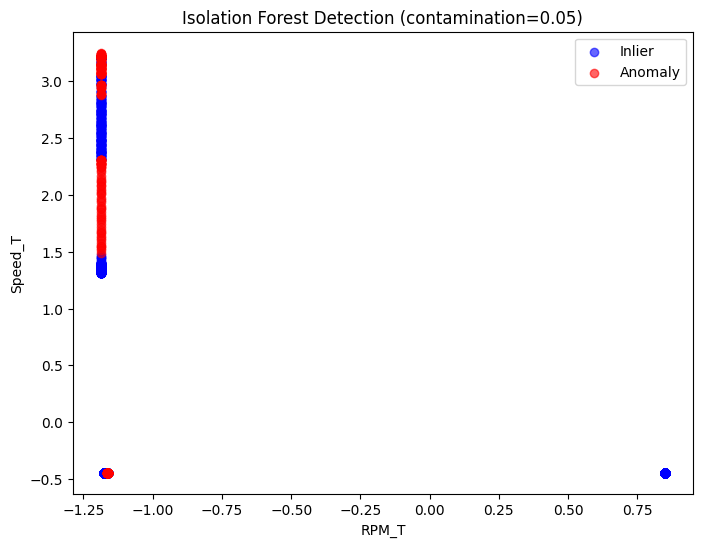

In [126]:
isolation_forest_scater_clusters(no_injection_df[['RPM_T', 'Speed_T']],
                               contamination=0.05)

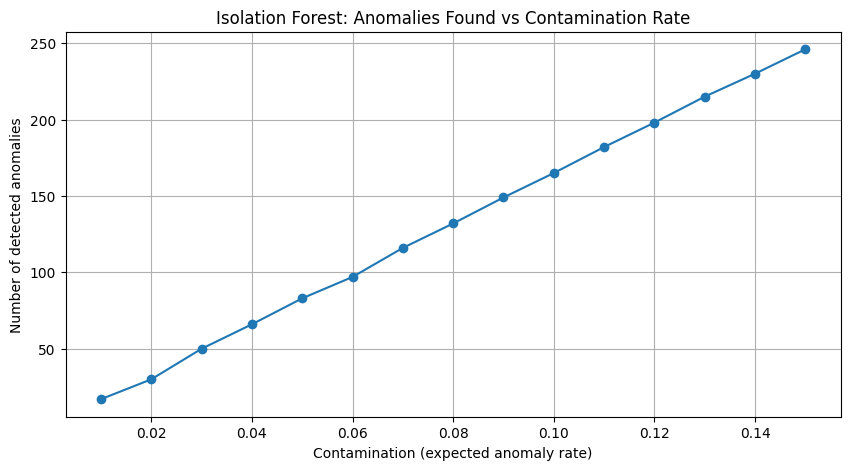

In [127]:
isolation_forest_graphs(rpm_injection_df[['RPM_T', 'Speed_T']], 15)

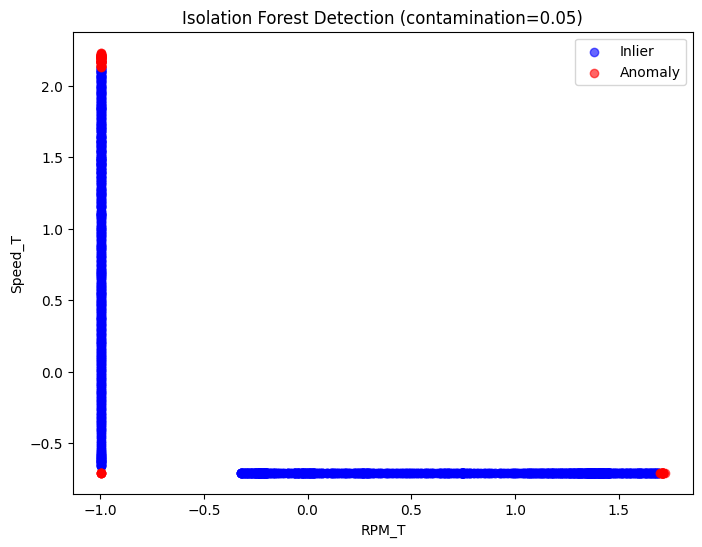

In [128]:
isolation_forest_scater_clusters(rpm_injection_df[['RPM_T', 'Speed_T']],
                               contamination=0.05)

In [129]:
anomalies_df, accuracy = isolation_forest_anomalies_accuracy(
    fff_injection_df[['RPM_T', 'Speed_T']],
    known_labels=fff_injection_df['Attack'],
    contamination=0.05
)

      RPM_T   Speed_T
0  1.037652 -1.521978
1 -0.505050 -1.521978
2  1.032724 -1.521978
3 -0.505050 -1.521978
4  1.032724 -1.521978
Accuracy: 0.5026671285071008


In [130]:
anomalies_df, accuracy = isolation_forest_anomalies_accuracy(
    no_injection_df[['RPM_T', 'Speed_T']],
    known_labels=no_injection_df['Attack'],
    contamination=0.05
)

         RPM_T   Speed_T
2044 -1.186355  1.491725
2047 -1.164304 -0.443649
2051 -1.186355  1.515094
2052 -1.164149 -0.443649
2056 -1.163900 -0.443649
Accuracy: 0.5020911292097733


In [131]:
anomalies_df, accuracy = isolation_forest_anomalies_accuracy(
    rpm_injection_df[['RPM_T', 'Speed_T']],
    known_labels=rpm_injection_df['Attack'],
    contamination=0.05
)


       RPM_T   Speed_T
1  -0.995494 -0.707628
3  -0.995494 -0.707628
5  -0.995494 -0.707628
8  -0.995494 -0.707628
10 -0.995494 -0.707628
Accuracy: 0.5009096422073984


Task 4

In [153]:
def hidden_markov_model_states(data, max_states):
    aic_scores = []
    bic_scores = []
    n_states = range(1, max_states+1)

    for n in n_states:
        model = GaussianHMM(n_components=n, covariance_type='full', n_iter=200, random_state=42)
        model.fit(data)
        bic_scores.append(model.bic(data))
        aic_scores.append(model.aic(data))

    plt.figure(figsize=(10, 5))
    plt.plot(n_states, aic_scores, 'o-', label='AIC')
    plt.plot(n_states, bic_scores, 's-', label='BIC')
    plt.xlabel('Number of Hidden Markov Model')
    plt.ylabel('Criterion Value (lower is better)')
    plt.title('Model Selection Hidden Markov Model')
    plt.legend()
    plt.grid(True)
    plt.show()

In [154]:
def hidden_markov_model_scater(data, n_states=2):
    hmm = GaussianHMM(n_components=n_states, covariance_type='full', n_iter=200, random_state=42)
    hmm.fit(data)
    states = hmm.predict(data)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=states, cmap='viridis', s=50)
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.title(f'Hidden Markov Model Fitted Hidden States (n_states={n_states})')
    plt.legend(*scatter.legend_elements(), title="HMM State")
    plt.show()

In [161]:
def hmm_states_accuracy(df, known_labels=None, n_states=2):
    hmm = GaussianHMM(n_components=n_states, covariance_type='full', n_iter=200, random_state=42)
    hmm.fit(df)
    state_sequence = hmm.predict(df)

    accuracy = None
    if known_labels is not None:
        acc1 = accuracy_score(known_labels, state_sequence)
        acc2 = accuracy_score(known_labels, 1 - state_sequence)
        accuracy = max(acc1, acc2)
        print(f"Hidden Markov Value accuracy: {accuracy:.4f}")

    return state_sequence, accuracy


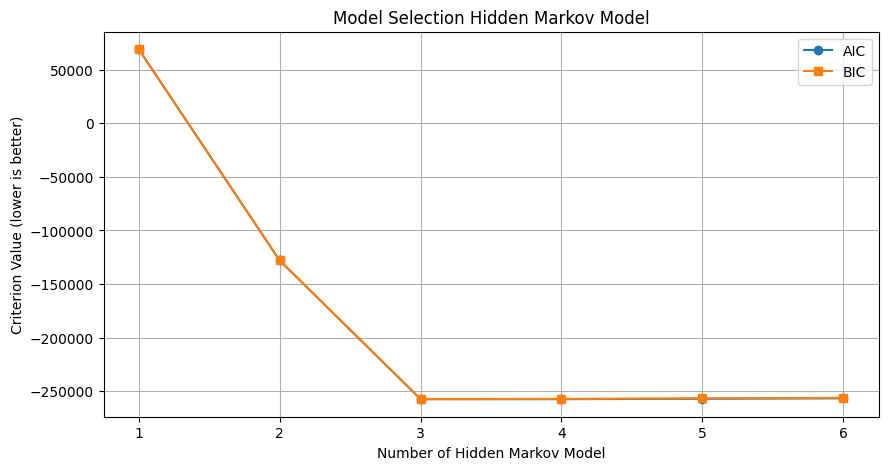

In [165]:
hidden_markov_model_states(fff_injection_df[['RPM_T', 'Speed_T']], 6)

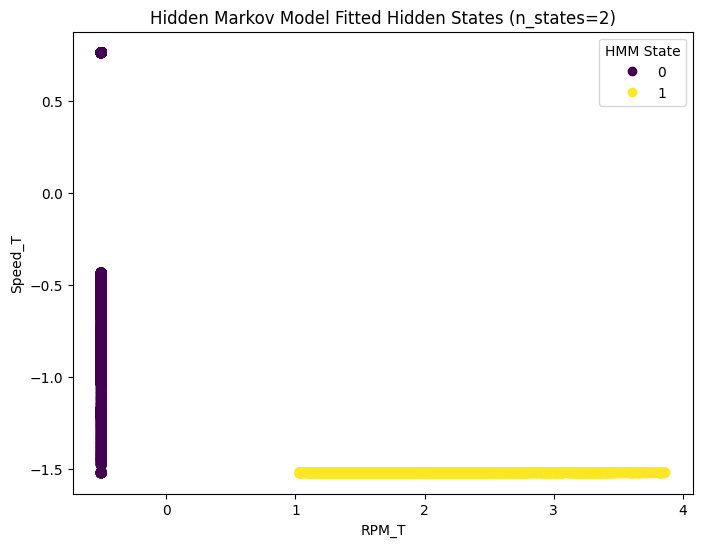

In [166]:
hidden_markov_model_scater(fff_injection_df[['RPM_T', 'Speed_T']], n_states=2)

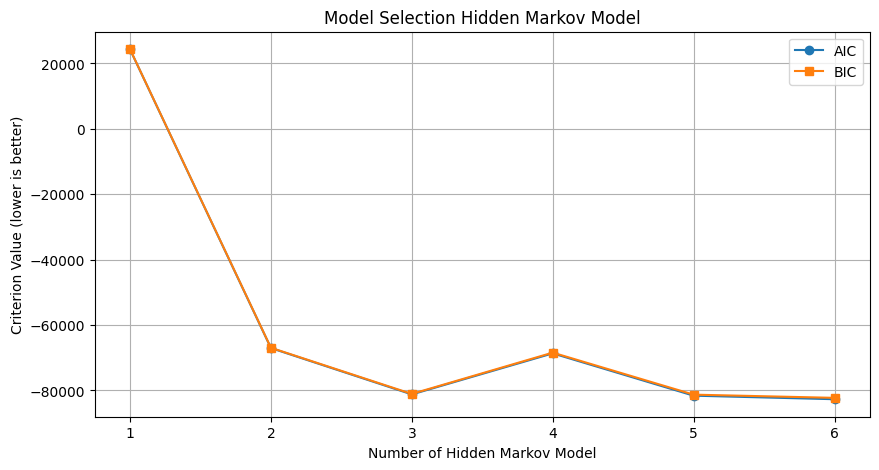

In [167]:
hidden_markov_model_states(no_injection_df[['RPM_T', 'Speed_T']], 6)

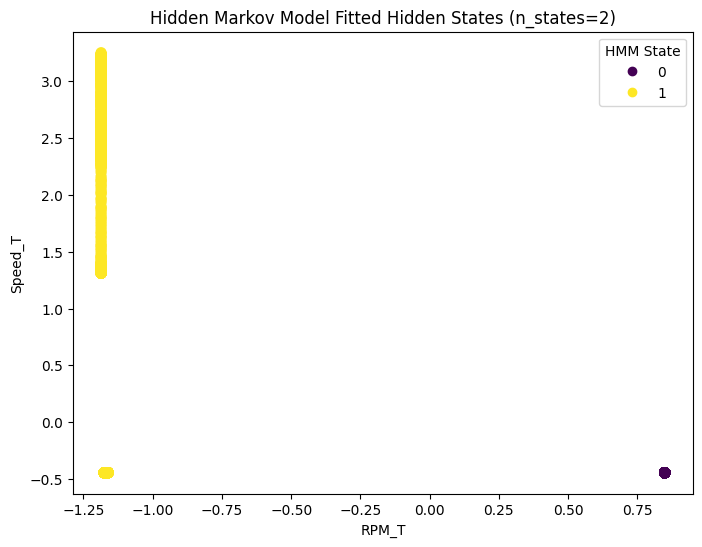

In [168]:
hidden_markov_model_scater(no_injection_df[['RPM_T', 'Speed_T']], n_states=2)

In [176]:
hidden_markov_model_states(rpm_injection_df[['RPM_T', 'Speed_T']], 6)

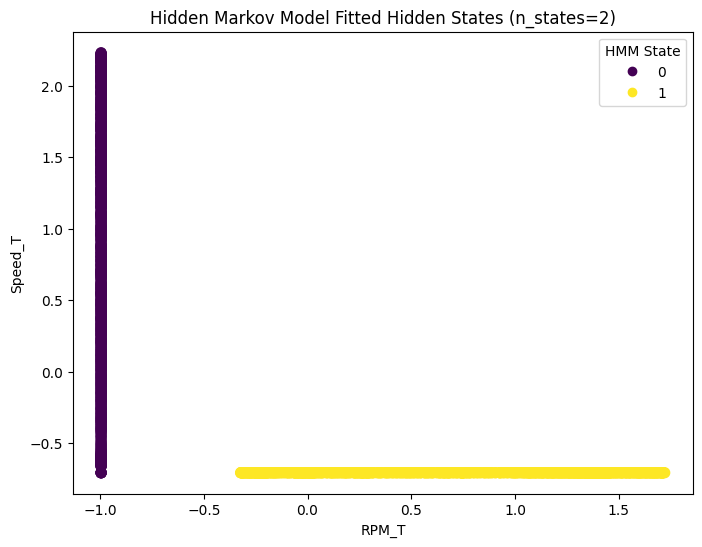

In [171]:
hidden_markov_model_scater(rpm_injection_df[['RPM_T', 'Speed_T']], n_states=2)


In [173]:
state_sequence, accuracy = hmm_states_accuracy(
    fff_injection_df[['RPM_T', 'Speed_T']],
    known_labels=fff_injection_df['Attack'],
    n_states=2
)

Hidden Markov Value accuracy: 0.5057


In [174]:
state_sequence, accuracy = hmm_states_accuracy(
    no_injection_df[['RPM_T', 'Speed_T']],
    known_labels=no_injection_df['Attack'],
    n_states=2
)

Hidden Markov Value accuracy: 0.5129


In [175]:
state_sequence, accuracy = hmm_states_accuracy(
    rpm_injection_df[['RPM_T', 'Speed_T']],
    known_labels=rpm_injection_df['Attack'],
    n_states=2
)

Hidden Markov Value accuracy: 0.5100
